In [1]:
import numpy as np
import os
import glob
import time
#import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
#import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tqdm import tqdm
import sys


2024-03-19 10:14:05.610923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 10:14:05.611047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 10:14:05.761109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (224, 224) 
bach_size = 128 
img_dir = r'/kaggle/input/birdies/images'
label_dir = r'/kaggle/input/birdies/labels'
working_dir = r'/kaggle/working/'
test_dir = r'/kaggle/input/birdies/test images'

In [3]:
def get_box(label_dir, img_size): \
    # оптимизировано для диапазона чисел не более 2^16
    with open(label_dir) as f: # открытие файлов в ириктории
        line=f.readline()    
    box_params = line.split() # разделяем числа по пробелу
    xc = np.float16(box_params[1]) * img_size[1] # центр картинки по x
    yc = np.float16(box_params[2]) * img_size[0]   # центр картинки по y 
    
    bw = np.float16(box_params[3]) * img_size[1] # ширина
    bh = np.float16(box_params[4]) * img_size[0] # высота

    # отрисовка линий ящика
    x_min = np.int16((xc - bw/2)) # отложим от центра половину ширины вправо и влево
    
    x_max = np.int16((xc + bw/2))
    y_min = np.int16((yc - bh/2)) # отложим от центра половину длины вправо и влево
    
    y_max = np.int16((yc + bh/2))
    
    return x_min, y_min, x_max, y_max

# 

In [4]:
get_box(label_dir + '/0010.txt', img_size)

(67, 20, 155, 217)

## Отрисуем ящики на картинках

In [5]:
# Подготовка путей и данных
img_list = np.sort(os.listdir(img_dir))
label_list = np.sort(os.listdir(label_dir))
zip_list = zip(img_list, label_list) # генератор


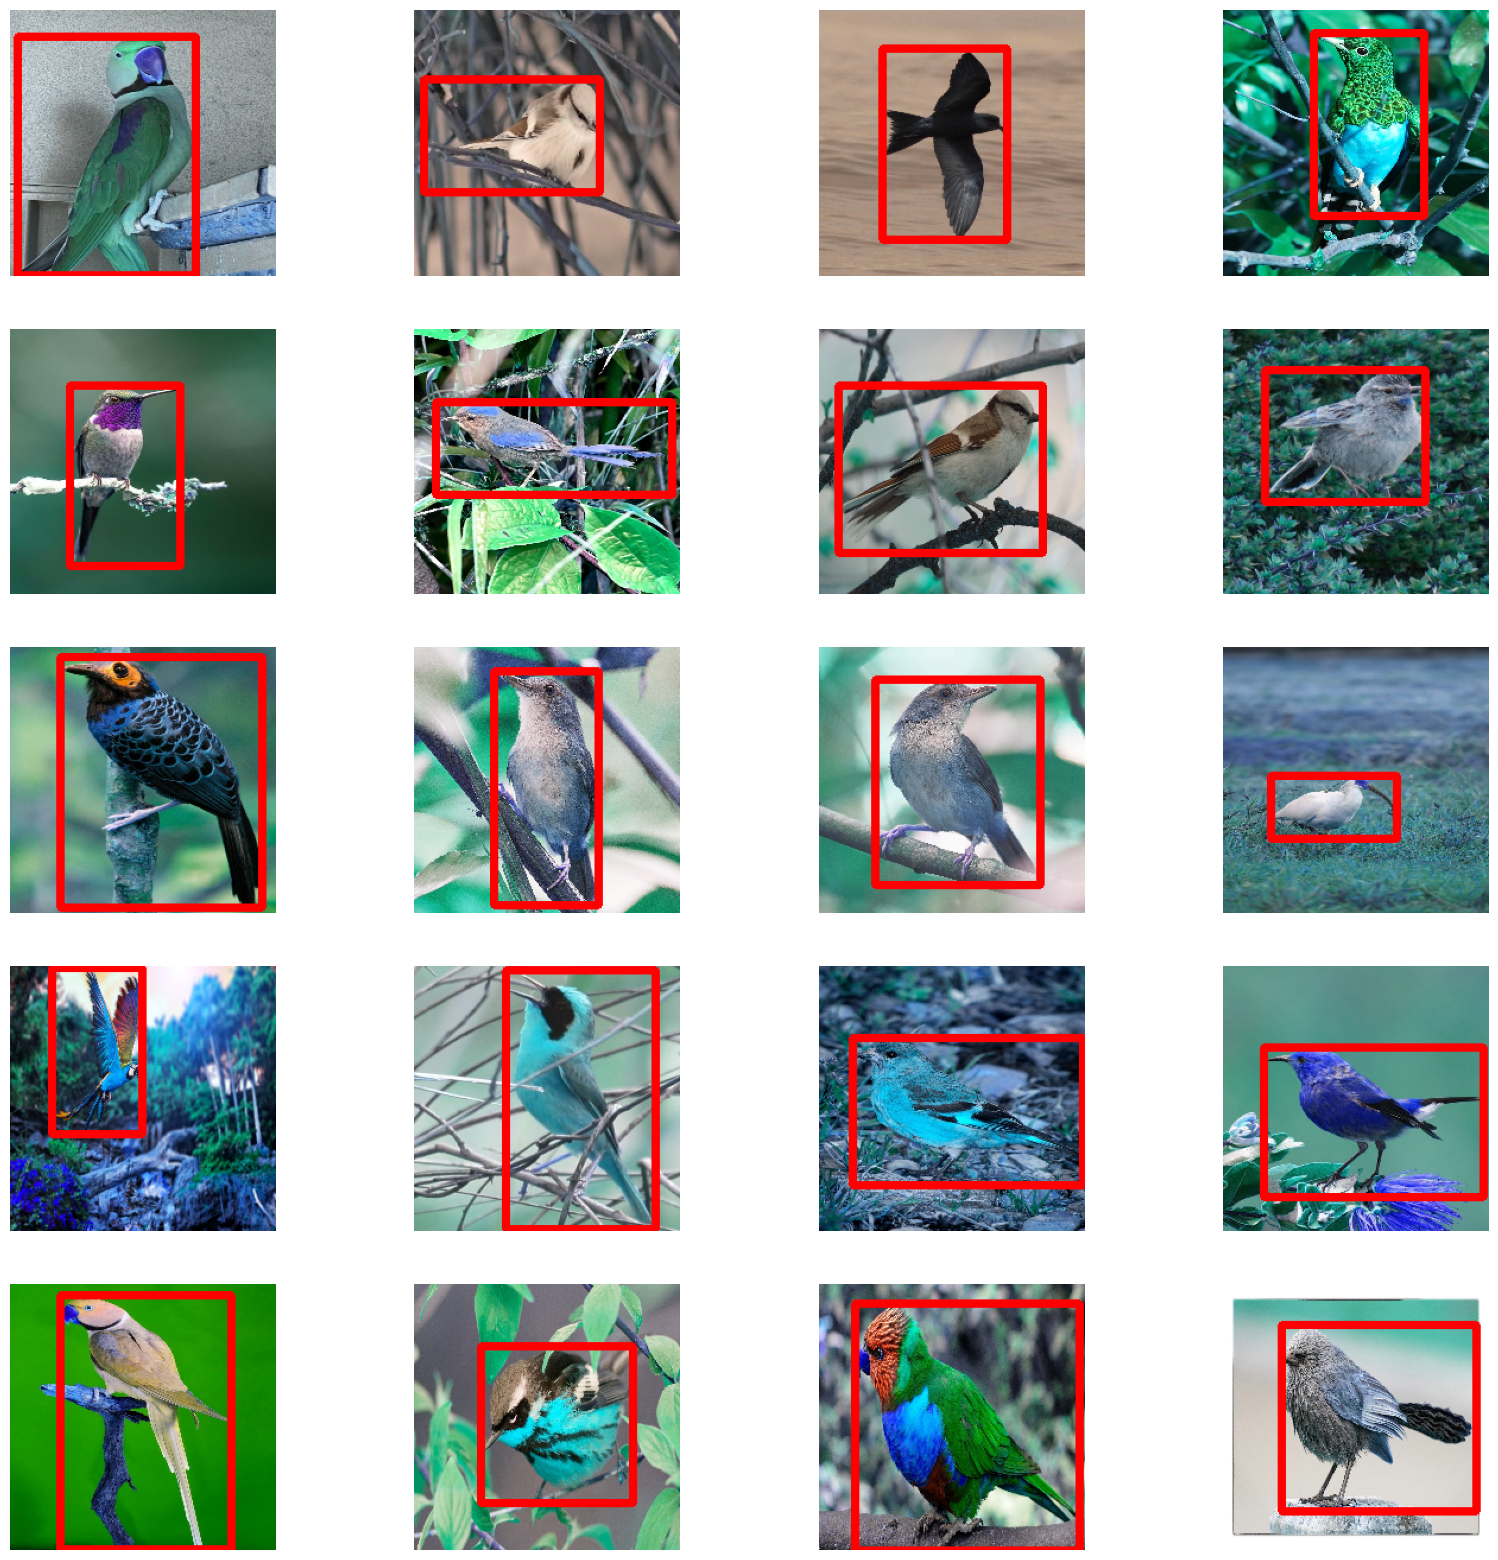

In [6]:
plt.figure(figsize=(20,20))
i=0
for img, box in zip_list:
    img_path = os.path.join(img_dir, img) # соеденяем в путь к конкретной картинки
    label_path = os.path.join(label_dir, box) # получаем путь ящика
    img_draw = cv2.imread(img_path)
    img_draw = cv2.resize(img_draw, img_size)
    xmin, ymin, xmax, ymax = get_box(label_path, img_size)      
        
    cv2.rectangle(img_draw, (xmin, ymin), (xmax, ymax), (255,0,0), 6) # рисуем прямоугольник на картинки
    plt.subplot(5,4, i+1)
    plt.axis('off')
    plt.imshow(img_draw)
    i += 1
 
    if i >= 20:
        break
plt.show()

In [7]:
%time
def make_data(img_list, label_list, img_dir,label_dir, img_size):
    zip_list = zip(img_list, label_list)
    boxes = np.array([])  
    images = np.array([])
    i = 1
    count = len(img_list)
    for img, label in zip_list:
        msg = f'processing image {i} of  {count}'
        i += 1
        print(msg, '\r', end='')
        img_path = os.path.join(img_dir, img)
        labelpath = os.path.join(label_dir, label)
        img_read = cv2.imread(img_path)
        img_read = cv2.resize(img_read, img_size)
        
        
        xmin, ymin, xmax, ymax= get_box(label_path, img_size)  
        box = [xmin, ymin, xmax, ymax] 
        
        images = np.append(images, img_read)
        boxes = np.append(boxes, box)

    trimages,vimages,trboxes,vboxes=train_test_split(images, boxes, train_size=.7,
                                                   shuffle=True, random_state=42)   
    return trimages, trboxes, vimages, vboxes

trimages, trboxes, vimages, vboxes=make_data(img_list, label_list, img_dir,label_dir, img_size)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


ValueError: Found input variables with inconsistent numbers of samples: [302561280, 8040]

In [ ]:
%time
def make_data(img_list, label_list, img_dir,label_dir, img_size):
    zip_list = zip(img_list, label_list)
    boxes = []
    images = []
    i = 1
    count = len(img_list)
    for img, label in zip_list:
        msg = f'processing image {i} of  {count}'
        i += 1
        print(msg, '\r', end='')
        img_path = os.path.join(img_dir, img)
        labelpath = os.path.join(label_dir, label)
        img_read = cv2.imread(img_path)
        img_read = cv2.resize(img_read, img_size)
        
        
        xmin, ymin, xmax, ymax= get_box(label_path, img_size)  
        box = [xmin, ymin, xmax, ymax] 
        
        images.append(img_read)
        boxes.append(box)
    
    images = np.array(images)
    boxes =  np.array(boxes)
    trimages,vimages,trboxes,vboxes = train_test_split(images, boxes, train_size=.7,
                                                   shuffle=True, random_state=42)   
    return trimages, trboxes, vimages, vboxes

trimages, trboxes, vimages, vboxes=make_data(img_list, label_list, img_dir,label_dir, img_size)

In [ ]:
%time
def make_data(imgdir, labeldir, img_size):
    imglist=sorted(os.listdir(img_dir))
    labellist=sorted(os.listdir(label_dir))
    ziplist=zip(imglist, labellist)
    boxes=[]    
    list_of_images=[]
    i=1
    fcount=len(imglist)
    for fimg, flabel in ziplist:
        msg=f'              processing image {i} of  {fcount}'
        i +=1
        print(msg, '\r', end='')
        imgpath=os.path.join(img_dir, fimg)
        labelpath=os.path.join(label_dir, flabel)
        img=cv2.imread(imgpath)
        img=cv2.resize(img, img_size)
        list_of_images.append(img)
        shape=img.shape
        xmin, ymin, xmax, ymax= get_box(labelpath, shape)  
        box=[xmin, ymin, xmax, ymax]         
        boxes.append(box)
        
    images=np.array(list_of_images)
    boxes=np.array(boxes)
    trimages,vimages,trboxes,vboxes=train_test_split(images, boxes, train_size=.8,
                                                   shuffle=True, random_state=123)   
    return trimages, trboxes, vimages, vboxes

trimages, trboxes, vimages, vboxes=make_data(img_list, label_list, img_size)